In [ ]:
#!jt -t chesterish


Dorrit0, dorrit1, jelle0, night0, night1

In [193]:
data_path_old = r"C:\Users\Fin Amin\Desktop/\StemCellResearch\datasets_Sahil_preprocessed_final-20220525T021621Z-001\datasets_Sahil_preprocessed_final\exp1"
matrix_path = "regulator-gene-matrix.csv"
data_path_syn = r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\synData"
data_path_inter =  r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\interpolatedOnly"
data_path_og_exp1 = r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\datasets\exp1"
data_path_testSet = r"C:\Users\Fin Amin\Desktop\StemCellResearch\testSetFixed"


In [194]:
'''Run to test on testSet'''
#data_path_og_exp1 = data_path_testSet 

'Run to test on testSet'

In [195]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import*

# from keras.layers import Input
# from keras.layers import Dense
# from keras.layers import Conv1D
# from keras.layers import Conv1DTranspose
# from keras.layers import Flatten, Reshape

import os
from glob import glob
from tqdm import tqdm

In [196]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Load the test set and the synthetic dataset:


In [238]:
def loadTestSet(test_path):
    testFiles = []
    for np_name in glob(os.path.join(data_path_testSet,'*.np[yz]')):
        k = np.load(os.path.join(data_path_testSet,np_name))
        testFiles.append(k)
#         print(np_name)
#         print(k.shape)
    return np.array(testFiles)

In [239]:
test = loadTestSet(data_path_testSet)


In [210]:
def read_files(data_path):
    '''
    *Changed*
    currently hardcoded for only one file. 
    change code a bit for reading multiple files.
    '''
    #genes_intensities_data_matrix = pd.read_csv(file_path_intensities, index_col = 0)
    #print(os.listdir(data_path))
    replicate_files = os.listdir(data_path)
    #print('replicate files:',replicate_files)
    replicates = []
    # i = 0
    for file in replicate_files:
        
        try:
            #print('file name:',file)
            #print('value of i:',i)
            genes_intensities_data_matrix = pd.read_csv(os.path.join(data_path , file), index_col = 0, on_bad_lines='skip')
            #print('genes_intensities_data_matrix:',  genes_intensities_data_matrix.head())
            replicates.append(np.array(genes_intensities_data_matrix.values, dtype = float))
            # i+=1
        except PermissionError:
            print("Not a CSV: ", os.path.join(data_path , file))
        
    genes_intensities_data_matrix = genes_intensities_data_matrix.values
    rgm = np.loadtxt(matrix_path)
    rep = np.array(replicates).astype(np.float32)
    
    return rep, rgm.astype(np.float32)

In [211]:
genes_intensities_normalized, regulator_gene_matrix= read_files(data_path_syn)
matrix = regulator_gene_matrix
replicates = genes_intensities_normalized

In [212]:
matrix.shape

(245, 245)

In [213]:
replicates.shape

(6, 6, 245)

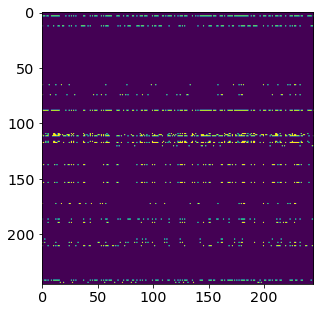

In [214]:
plt.imshow(matrix)

In [215]:
#%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [216]:
class EncoderLinear(keras.layers.Layer):
    def __init__(self, rgm, input_dim=32, units=32):
        super(EncoderLinear, self).__init__()
        self.rgm = rgm
        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.rgm, dtype=dtype)

            return w_init
        

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

In [217]:
class DecoderLinear(keras.layers.Layer):
    def __init__(self, rgm, input_dim=32, units=32):
        super(DecoderLinear, self).__init__()
        self.rgm = rgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.rgm, dtype=dtype))

            return w_init
    
        
        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        #return tf.matmul(X, tf.multiply((self.rgm), self.w))
        X = tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) 
        #return tf.matmul(inputs, self.w)
        v = tf.zeros_like(X)
        u = tf.ones_like(X)
        u = tf.math.scalar_mul(-1.0, u)
        
        return tf.where(tf.math.less(X, v), u, X) #where X is less than 0, return -1 
        
        

In [218]:
def encoder(parent_child_biological_association, num_hidden_units=2):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    en_conv = Conv1D(32, 3, activation = "relu")(parent_child_biological_association) # 6*245
    en_dense = Flatten()(en_conv)
    phenotype = Dense(num_hidden_units)(en_dense)
    return phenotype

def decoder(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(128)(X)
    de_dense = Reshape((1, 128))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "relu")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def model(rgm, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 2):
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = EncoderLinear(rgm, 245, 245)(inp)
    enc = encoder(x, num_hidden_units)
    dec = decoder(enc, num_protein_gene, time_steps)
    out = DecoderLinear(rgm, 245, 245)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [219]:
regulator_gene_matrix = matrix# np.random.randint(0, 2, size=(245, 245)).astype(np.float32)


In [220]:
enc_dec_Synthetic = model(regulator_gene_matrix, 245, 6, 245) #we can just change the time steps to something higher

In [221]:
enc_dec_Synthetic.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 6, 245)]          0         
                                                                 
 encoder_linear_4 (EncoderLi  (None, 6, 245)           60025     
 near)                                                           
                                                                 
 conv1d_4 (Conv1D)           (None, 4, 32)             23552     
                                                                 
 flatten_4 (Flatten)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 2)                 258       
                                                                 
 dense_9 (Dense)             (None, 128)               384       
                                                           

# Create Super parent matrix. FOR USE LATER!!

In [222]:
from tensorflow.keras import losses

In [223]:
superParent = regulator_gene_matrix.copy()
#print(superParent.shape)

ones = np.ones((245))
parentIndex = []
for i in range(len(regulator_gene_matrix)):
    if (np.isin(regulator_gene_matrix[i], [1])).any():
        #print(i)
        superParent[i] = ones 
        parentIndex.append(i)
parentIndex = np.array(parentIndex)
parentIndex = tf.convert_to_tensor(parentIndex)

def ignore_noParent_MSE(y_true, y_pred): 
    l = tf.keras.losses.MeanSquaredError()
    y_true_pruned = tf.gather(y_true,parentIndex, axis =2)
    #print(y_true_pruned.shape
    y_pred_pruned = tf.gather(y_pred, parentIndex, axis =2)   
    return l(y_true_pruned, y_pred_pruned)

In [224]:
enc_dec_Synthetic.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [225]:
# enc_dec_Synthetic.compile(optimizer='adam',loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True))

# Train on bottom 5 synthetic datasets (all but first experiment)

In [226]:
enc_dec_Synthetic.fit(genes_intensities_normalized[1:],genes_intensities_normalized[1:],epochs=10)

Epoch 1/10
1/1 [==============================] - 1s 681ms/step - loss: 1.4058
Epoch 2/10
1/1 [==============================] - 0s 1ms/step - loss: 1.2881
Epoch 3/10
1/1 [==============================] - 0s 29ms/step - loss: 1.2155
Epoch 4/10
1/1 [==============================] - 0s 11ms/step - loss: 1.1529
Epoch 5/10
1/1 [==============================] - 0s 11ms/step - loss: 1.0848
Epoch 6/10
1/1 [==============================] - 0s 11ms/step - loss: 1.0570
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 1.0259
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.9821
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.9312
Epoch 10/10
1/1 [==============================] - 0s 6ms/step - loss: 0.9131


In [227]:
w = enc_dec_Synthetic.get_weights()

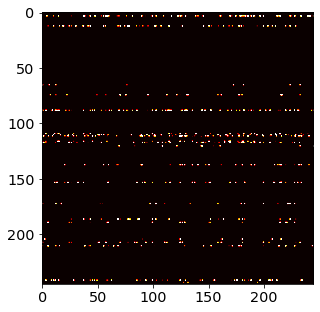

In [228]:
plt.imshow(w[0], cmap = "hot", vmin=0,vmax=0.02)

# The output of the auto encoder trained on synthetic data. Autoencoder has not been trained on synthetic version of experiement 1. We test on the original experiment 1. TODO: test on testset

In [229]:
#we do not need to use this function for the testset
def getCSVs(data_path_head):
    PATH = data_path_head
    EXT = "*.csv"
    all_csv_files = [file
                     for path, subdir, files in os.walk(PATH)
                     for file in glob(os.path.join(path, EXT))]
    actual = []
    for p in all_csv_files:
        actual.append(pd.read_csv(p, index_col = 0).to_numpy())
    return np.array(actual)
    
#testCandidate = getCSVs(data_path_og_exp1)

In [241]:
testCandidate = test.astype(np.float)

C:\Users\Fin Amin\AppData\Local\Temp\ipykernel_11164\1882554214.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  testCandidate = test.astype(np.float)


In [244]:
testCandidate.dtype

dtype('float64')

In [245]:
np.array([genes_intensities_normalized[0]]).shape

(1, 6, 245)

In [246]:
testCandidate[0].shape

(6, 245)

In [247]:
np.array([genes_intensities_normalized[0]]).shape

(1, 6, 245)

In [249]:
outSyn = enc_dec_Synthetic.predict(testCandidate)

1/1 [==============================] - 0s 16ms/step


In [250]:
def mymagn(A, B):
    mse = (np.square(A - B)).mean(axis=None)
    return mse

In [251]:
syntheticLoss = ignore_noParent_MSE(outSyn, testCandidate)
syntheticLoss

<tf.Tensor: shape=(), dtype=float64, numpy=1.2090883746846182>

In [252]:
(outSyn-testCandidate).shape

(4, 6, 245)

# The autoencoder trained on the interpolated dataset. Once again, we do not train on any version of the original experiment. TODO: test on test set

In [253]:
def read_filesV2(data_path):
    '''
    *Changed*
    currently hardcoded for only one file. 
    change code a bit for reading multiple files.
    '''
    #genes_intensities_data_matrix = pd.read_csv(file_path_intensities, index_col = 0)
    #print(os.listdir(data_path))
    replicate_files = os.listdir(data_path)
    #print('replicate files:',replicate_files)
    replicates = []
    # i = 0
    for file in replicate_files:
        
        #print('file name:',file)
        #print('value of i:',i)
        genes_intensities_data_matrix = pd.read_csv(os.path.join(data_path , file), index_col = 0, on_bad_lines='skip')
        #print('genes_intensities_data_matrix:',  genes_intensities_data_matrix.head())
        replicates.append(genes_intensities_data_matrix.values)
        # i+=1
        
    genes_intensities_data_matrix = genes_intensities_data_matrix.values
    rgm = np.loadtxt(matrix_path)
    
    return np.asarray(replicates), rgm.astype(np.float32)

In [254]:
interpolated_genes, _ = read_filesV2(data_path_inter)

C:\Users\Fin Amin\AppData\Local\Temp\ipykernel_11164\3349346019.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(replicates), rgm.astype(np.float32)


In [255]:
interpolated_genes.shape

(5,)

In [256]:
pd.DataFrame(interpolated_genes[2]).head(5)

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.254943,-1.000000,0.663585,0.440312,-1.000000,0.635664,0.734571,-1.000000,0.312044,0.602692,...,-1.000000,0.400712,-1.000000,0.523033,-1.000000,0.561590,0.403879,0.642049,-1.000000,0.443478
1,0.338509,-1.000000,0.612395,0.655007,-1.000000,-1.000000,0.590564,-1.000000,0.353872,0.539972,...,-1.000000,0.445519,-1.000000,0.586067,-1.000000,0.541903,0.426403,0.495559,0.550973,0.419991
2,-1.000000,0.544463,0.596307,0.596367,-1.000000,0.629406,0.579586,0.726602,-1.000000,0.535278,...,0.509166,-1.000000,-1.000000,0.642262,-1.000000,0.586480,0.569283,-1.000000,0.596188,-1.000000
3,-0.329754,-0.454583,-0.828393,0.582746,-0.689224,0.178233,0.309607,-0.297329,-0.461788,0.493608,...,-0.024981,-0.697509,-0.153204,0.546957,0.161868,0.291320,-0.109625,-0.444279,0.007077,-0.254379
4,-1.000000,0.528085,-1.000000,0.523557,-1.000000,0.588043,0.580612,-1.000000,0.354997,0.567674,...,0.573489,0.392001,-1.000000,0.602732,-1.000000,0.544163,0.423905,-1.000000,0.578650,-1.000000


In [257]:
inter = []
for k in range(len(interpolated_genes)):
    #print(k)
    if k == 2 or k == 3 or k == 4:
        inter.append(np.reshape(interpolated_genes[k], (4,6,245)))
    else: 
        inter.append(np.reshape(interpolated_genes[k], (5,6,245)))
inter = np.vstack(inter)

In [258]:
inter.shape

(22, 6, 245)

In [259]:
genes_intensities_normalized[1:].shape

(5, 6, 245)

In [260]:
enc_dec_inter = model(regulator_gene_matrix, 245, 6, 245) 
enc_dec_inter.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [261]:
enc_dec_inter.fit(inter, inter,epochs=10);

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.8810
Epoch 2/10
1/1 [==============================] - 0s 16ms/step - loss: 0.7950
Epoch 3/10
1/1 [==============================] - 0s 0s/step - loss: 0.7612
Epoch 4/10
1/1 [==============================] - 0s 0s/step - loss: 0.7311
Epoch 5/10
1/1 [==============================] - 0s 20ms/step - loss: 0.7113
Epoch 6/10
1/1 [==============================] - 0s 4ms/step - loss: 0.6999
Epoch 7/10
1/1 [==============================] - 0s 4ms/step - loss: 0.6958
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6621
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6577
Epoch 10/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6505


In [262]:
outInter = enc_dec_inter.predict(testCandidate)
interpolationLoss = ignore_noParent_MSE(outInter, testCandidate)

1/1 [==============================] - 0s 107ms/step


In [263]:
interpolationLoss

<tf.Tensor: shape=(), dtype=float64, numpy=1.3098661392480786>

In [264]:
outInter.shape

(4, 6, 245)

In [265]:
u = enc_dec_inter.history
u

In [266]:
interpolationLoss

<tf.Tensor: shape=(), dtype=float64, numpy=1.3098661392480786>

# We have the comparisons between various outputs:

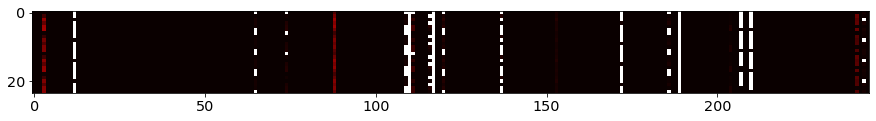

In [267]:
u = plt.imshow(np.reshape((np.abs(outSyn)), (24,245)), cmap = "hot", vmin=0,vmax=1.0 );

In [268]:
u = pd.DataFrame(outSyn[0])
u.head(10)

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.0,0.0,0.0,0.004865,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.002031,0.0,0.018466,0.0
1,0.0,0.0,0.0,0.078410,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.146009,0.0,0.010695,0.0
2,0.0,0.0,0.0,0.207921,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.123167,0.0,-1.000000,0.0
3,0.0,0.0,0.0,0.133153,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.132602,0.0,0.024965,0.0
4,0.0,0.0,0.0,0.222046,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.005606,0.0,0.007105,0.0
5,0.0,0.0,0.0,0.226962,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.141540,0.0,0.021203,0.0


In [269]:
u = pd.DataFrame(testCandidate[0])
u.head(10)

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.630290,0.629271,0.688235,0.332625,0.572247,0.651327,0.709770,0.276510,0.461589,0.442091,...,0.811426,0.836935,0.348147,0.348147,0.425058,0.390865,0.572641,0.605758,0.520441,0.460282
1,0.679429,0.598782,0.679060,0.312948,0.501809,0.694769,0.736314,-1.000000,0.562616,0.502785,...,0.803799,0.773869,0.430436,0.430436,0.520618,0.377990,0.629725,0.627226,0.603480,-1.000000
2,0.679668,0.569034,0.660106,0.321653,0.508297,0.685786,0.704436,-1.000000,0.527585,0.458724,...,0.829671,0.841796,0.414461,0.414461,0.429398,0.384251,0.617261,0.631014,0.578434,0.455383
3,0.622666,0.631905,0.664430,0.362718,0.481386,0.650971,0.754691,0.182870,0.517533,0.484508,...,0.737947,0.772426,0.345331,0.345331,0.495079,0.376468,0.682103,0.500355,0.577239,0.456085
4,0.765695,0.592536,0.670325,0.447501,0.469679,0.588251,0.734281,-1.000000,0.501568,0.414366,...,0.784941,0.754746,0.363333,0.363333,0.494566,0.547184,0.614375,0.613839,0.533392,0.447694
5,0.909198,0.555930,0.600608,0.684593,0.566607,0.666201,0.678537,0.514692,0.496297,0.434962,...,0.761315,0.768105,0.408423,0.408423,0.488222,0.609201,0.674039,0.732528,0.536272,0.407899


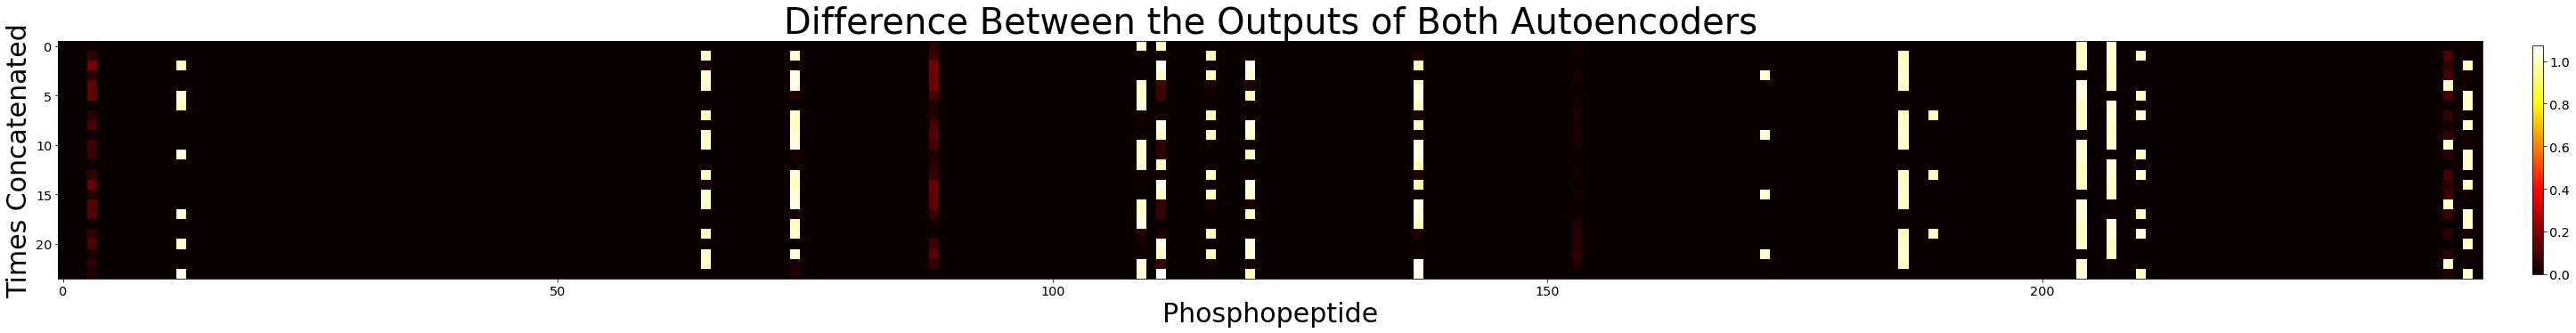

In [270]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape((np.abs(outSyn-outInter)), (24,245)), cmap = "hot")#, vmin=0,vmax=1.0 );
plt.title("Difference Between the Outputs of Both Autoencoders", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30);
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("DiffBetweenOut.png")

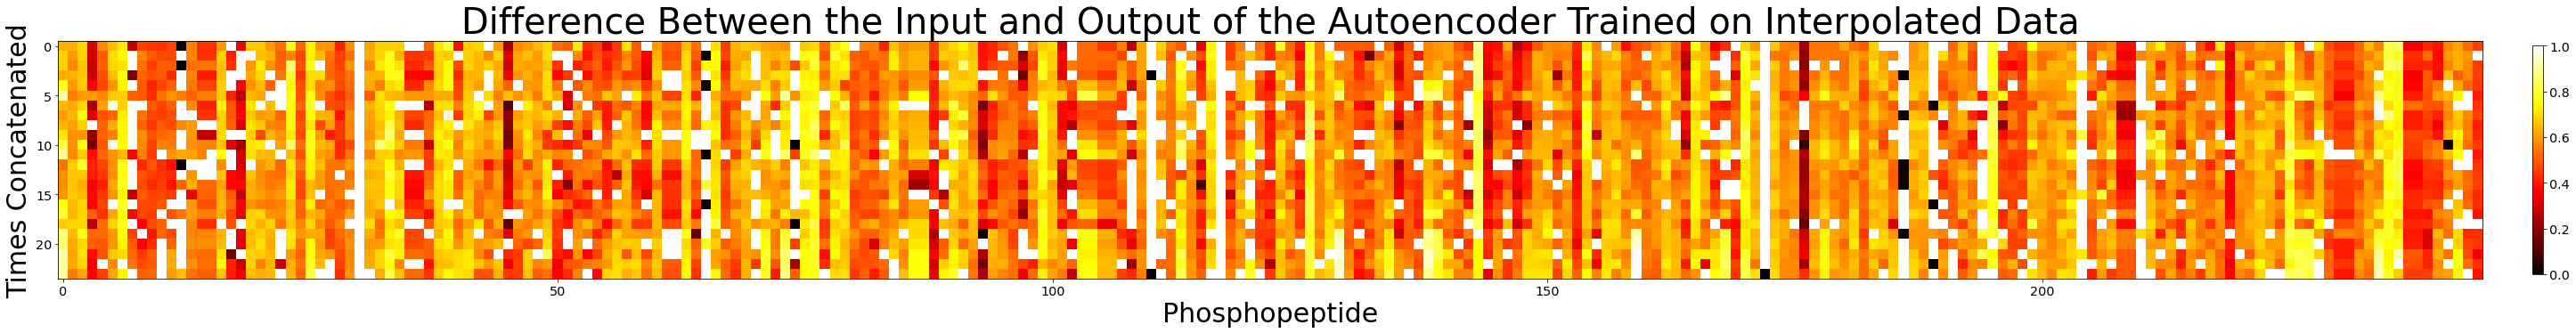

In [271]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape(np.abs(outInter-testCandidate), (24,245)) , cmap = "hot", vmin=0,vmax=1.0 )
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Interpolated Data", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30)
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02)
#plt.savefig("InterDiffImage.png")

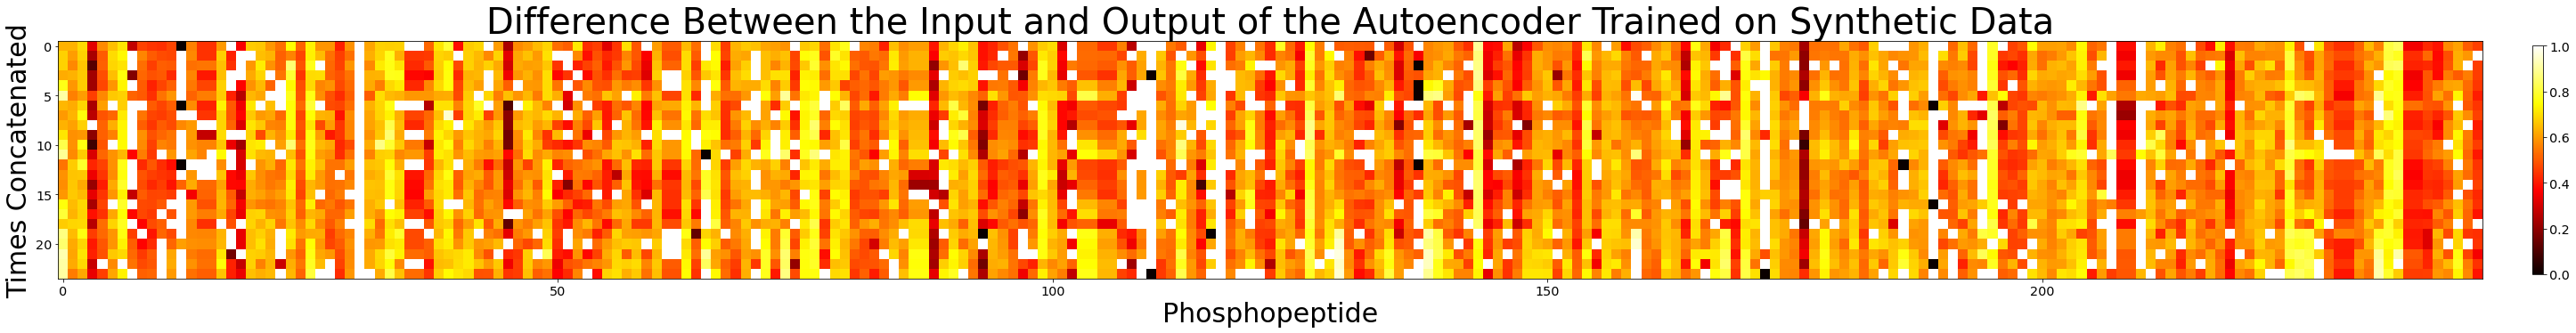

In [272]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape(np.abs(outSyn-testCandidate), (24,245)), cmap = "hot", vmin=0,vmax=1.0 )
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Synthetic Data", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30);
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("SynDiffImage.png");

In [273]:
u = pd.DataFrame(np.reshape(np.abs(outSyn), (24,245)))
u.head()

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.0,0.0,0.0,0.004865,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.002031,0.0,0.018466,0.0
1,0.0,0.0,0.0,0.078410,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.146009,0.0,0.010695,0.0
2,0.0,0.0,0.0,0.207921,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.123167,0.0,1.000000,0.0
3,0.0,0.0,0.0,0.133153,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.132602,0.0,0.024965,0.0
4,0.0,0.0,0.0,0.222046,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.005606,0.0,0.007105,0.0


In [274]:
# np.save("interpolated_.npy", inter) #the interpolated dataset
# np.save("synthetic_.npy", genes_intensities_normalized[1:]) # the synthetic dataset
# np.save("synOut.npy", outSyn) #the output of the encoder trained on synthetic data with the input being exp1
# np.save("interOut.npy", outInter) #the output of the encoder trained on interpolated data with the input being exp1

# Try using a super parent with the synthetic dataset because the synthetic dataset performed the best

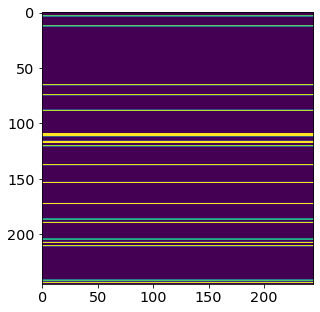

In [275]:
plt.imshow(superParent)

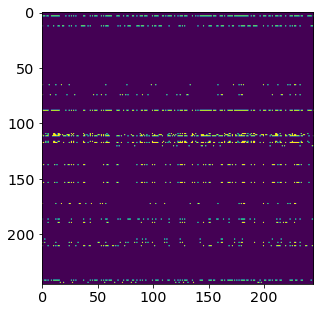

In [276]:
plt.imshow(regulator_gene_matrix)

In [277]:
looseParent = model(superParent, 245, 6, 245, 21)
looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
looseParent.fit(inter, inter, epochs=240)

Epoch 1/240
1/1 [==============================] - 1s 686ms/step - loss: 0.8427
Epoch 2/240
1/1 [==============================] - 0s 11ms/step - loss: 0.7706
Epoch 3/240
1/1 [==============================] - 0s 36ms/step - loss: 0.7338
Epoch 4/240
1/1 [==============================] - 0s 13ms/step - loss: 0.6861
Epoch 5/240
1/1 [==============================] - 0s 77ms/step - loss: 0.6592
Epoch 6/240
1/1 [==============================] - 0s 0s/step - loss: 0.6337
Epoch 7/240
1/1 [==============================] - 0s 37ms/step - loss: 0.5966
Epoch 8/240
1/1 [==============================] - 0s 14ms/step - loss: 0.5676
Epoch 9/240
1/1 [==============================] - 0s 37ms/step - loss: 0.5232
Epoch 10/240
1/1 [==============================] - 0s 17ms/step - loss: 0.4855
Epoch 11/240
1/1 [==============================] - 0s 52ms/step - loss: 0.4635
Epoch 12/240
1/1 [==============================] - 0s 20ms/step - loss: 0.4480
Epoch 13/240
1/1 [==============================] 

1/1 [==============================] - 0s 3ms/step - loss: 0.2035
Epoch 105/240
1/1 [==============================] - 0s 4ms/step - loss: 0.2045
Epoch 106/240
1/1 [==============================] - 0s 5ms/step - loss: 0.2033
Epoch 107/240
1/1 [==============================] - 0s 4ms/step - loss: 0.2036
Epoch 108/240
1/1 [==============================] - 0s 5ms/step - loss: 0.2025
Epoch 109/240
1/1 [==============================] - 0s 5ms/step - loss: 0.2025
Epoch 110/240
1/1 [==============================] - 0s 6ms/step - loss: 0.2025
Epoch 111/240
1/1 [==============================] - 0s 7ms/step - loss: 0.2025
Epoch 112/240
1/1 [==============================] - 0s 5ms/step - loss: 0.2028
Epoch 113/240
1/1 [==============================] - 0s 4ms/step - loss: 0.2028
Epoch 114/240
1/1 [==============================] - 0s 5ms/step - loss: 0.2032
Epoch 115/240
1/1 [==============================] - 0s 5ms/step - loss: 0.2028
Epoch 116/240
1/1 [==============================] - 0

1/1 [==============================] - 0s 5ms/step - loss: 0.2001
Epoch 207/240
1/1 [==============================] - 0s 5ms/step - loss: 0.2001
Epoch 208/240
1/1 [==============================] - 0s 4ms/step - loss: 0.2001
Epoch 209/240
1/1 [==============================] - 0s 5ms/step - loss: 0.2001
Epoch 210/240
1/1 [==============================] - 0s 5ms/step - loss: 0.2001
Epoch 211/240
1/1 [==============================] - 0s 5ms/step - loss: 0.2001
Epoch 212/240
1/1 [==============================] - 0s 4ms/step - loss: 0.2001
Epoch 213/240
1/1 [==============================] - 0s 5ms/step - loss: 0.2001
Epoch 214/240
1/1 [==============================] - 0s 4ms/step - loss: 0.2001
Epoch 215/240
1/1 [==============================] - 0s 0s/step - loss: 0.2001
Epoch 216/240
1/1 [==============================] - 0s 4ms/step - loss: 0.2001
Epoch 217/240
1/1 [==============================] - 0s 2ms/step - loss: 0.2001
Epoch 218/240
1/1 [==============================] - 0s

In [278]:
ignore_noParent_MSE(k := looseParent.predict(testCandidate), testCandidate)

1/1 [==============================] - 0s 91ms/step


<tf.Tensor: shape=(), dtype=float64, numpy=0.9070255728309489>

In [279]:
u = np.reshape(k, (24,245))
u = pd.DataFrame(u)
u.head()

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.0,0.0,0.0,0.243700,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.109378,0.0,0.106816,0.0
1,0.0,0.0,0.0,0.136859,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.249909,0.0,0.327131,0.0
2,0.0,0.0,0.0,0.320359,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.399465,0.0,0.235023,0.0
3,0.0,0.0,0.0,0.476803,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.157110,0.0,0.131866,0.0
4,0.0,0.0,0.0,0.346820,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.430216,0.0,0.542086,0.0


In [280]:
u = np.reshape(testCandidate, (24,245))
u = pd.DataFrame(u)
u.head()

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.630290,0.629271,0.688235,0.332625,0.572247,0.651327,0.709770,0.27651,0.461589,0.442091,...,0.811426,0.836935,0.348147,0.348147,0.425058,0.390865,0.572641,0.605758,0.520441,0.460282
1,0.679429,0.598782,0.679060,0.312948,0.501809,0.694769,0.736314,-1.00000,0.562616,0.502785,...,0.803799,0.773869,0.430436,0.430436,0.520618,0.377990,0.629725,0.627226,0.603480,-1.000000
2,0.679668,0.569034,0.660106,0.321653,0.508297,0.685786,0.704436,-1.00000,0.527585,0.458724,...,0.829671,0.841796,0.414461,0.414461,0.429398,0.384251,0.617261,0.631014,0.578434,0.455383
3,0.622666,0.631905,0.664430,0.362718,0.481386,0.650971,0.754691,0.18287,0.517533,0.484508,...,0.737947,0.772426,0.345331,0.345331,0.495079,0.376468,0.682103,0.500355,0.577239,0.456085
4,0.765695,0.592536,0.670325,0.447501,0.469679,0.588251,0.734281,-1.00000,0.501568,0.414366,...,0.784941,0.754746,0.363333,0.363333,0.494566,0.547184,0.614375,0.613839,0.533392,0.447694


In [281]:
N = 10
hidden = np.arange(2,33,8) #range(1,32)

lossMatrix = []
for i in tqdm(range(N)):
    
    losses = []
    for value in (hidden):
        looseParent = model(superParent, 245, 6, 245, value)
        looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
        looseParent.fit(genes_intensities_normalized, genes_intensities_normalized, epochs=20,  verbose=0)
        test = looseParent(testCandidate) #, verbose = 0)
        loss = ignore_noParent_MSE(test, testCandidate)
        losses.append(loss)
        tf.keras.backend.clear_session()
    lossMatrix.append(losses)
    
lossMatrix = np.array(lossMatrix)
#run 100 times 

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.71s/it]


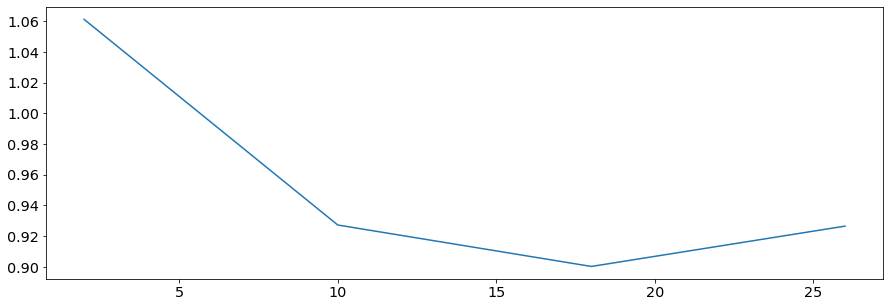

In [282]:
avgMSE = np.average(lossMatrix, axis = 0)
plt.plot(np.arange(2,33,8), avgMSE);

In [283]:
lossMatrix.shape

(10, 4)

In [284]:
avgMSE = np.average(lossMatrix, axis = 0)

In [285]:
avgMSE.shape

(4,)

In [286]:
#np.save("mse2.npy", avgMSE) #mse2/3 is with -1 fix

In [288]:
'''
a second copy of the layers which will be modified to be a denseNET auto encoder
'''
class EncoderLinear2(keras.layers.Layer):
    def __init__(self, rgm, input_dim=32, units=32):
        super(EncoderLinear2, self).__init__()
        self.rgm = rgm
        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.rgm, dtype=dtype)

            return w_init
        

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

class DecoderLinear2(keras.layers.Layer):
    def __init__(self, rgm, input_dim=32, units=32):
        super(DecoderLinear2, self).__init__()
        self.rgm = rgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.rgm, dtype=dtype))

            return w_init
    
        
        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        #return tf.matmul(X, tf.multiply((self.rgm), self.w))
        return tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) #used to have a transpose
        #return tf.matmul(inputs, self.w)
        

def encoder2(parent_child_biological_association, inp, num_hidden_units=2):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    en_conv = Conv1D(490, 3, activation = "tanh")(parent_child_biological_association) # 6*245
    en_dense = Flatten()(en_conv)
    inp = Flatten()(inp)
    #print(en_dense.shape, inp.shape)
    d = Concatenate()([en_dense, inp]) #dense layer
    en_dense = Dense(128)(d) #added a layer
    
    phenotype = Dense(num_hidden_units, activation="tanh")(d)
    return phenotype

def decoder2(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(128)(X)
    de_dense = Dense(128)(de_dense)#added a layer
    de_dense = Reshape((1, 128))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "tanh")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def model2(rgm, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 2):
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = EncoderLinear2(rgm, 245, 245)(inp)
    #x = EncoderLinear2(x)
    enc = encoder2(x, inp, num_hidden_units)
    dec = decoder2(enc, num_protein_gene, time_steps)
    out = DecoderLinear2(rgm, 245, 245)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [289]:
N = 10
hidden = np.arange(2,33,2) #range(1,32)

lossMatrix = []
for i in tqdm(range(N)):
    
    losses = []
    for value in (hidden):
        looseParent = model2(superParent, 245, 6, 245, value)
        looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
        looseParent.fit(genes_intensities_normalized, genes_intensities_normalized, epochs=20,  verbose=0)
        test = looseParent(testCandidate) #, verbose = 0)
        loss = ignore_noParent_MSE(test, testCandidate)
        losses.append(loss)
        tf.keras.backend.clear_session()
    lossMatrix.append(losses)
    
lossMatrix = np.array(lossMatrix)
#run 100 times 

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:34<00:00, 15.43s/it]


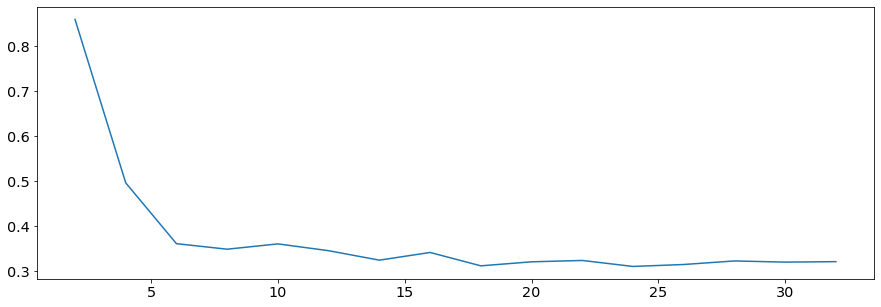

In [290]:
avgMSE = np.average(lossMatrix, axis = 0)
plt.plot(np.arange(2,33,2), avgMSE);

In [ ]:
#np.save("mse3.npy", avgMSE) #mse2/3 is with -1 fix

In [ ]:
#https://www.sciencedirect.com/science/article/pii/S0925231220314570?casa_token=lcEJANqO0JwAAAAA:uL3DGUZctPUZz_sPz1K1i2klMtb83TyKnc9CI3_N-uSOaM7VHL8GhM0jCGYfo25NmpDQQ9Cvlw